In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import calendar
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock
from warnings import filterwarnings
filterwarnings('ignore')

c = calendar.Calendar(firstweekday=calendar.SUNDAY)

def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

# def new_next_exp(today):

#     today = dt.datetime.strptime(today, '%Y-%m-%d')

#     next_mon = today + relativedelta.relativedelta(months=1)
#     nnext_mon = next_mon + relativedelta.relativedelta(months=1)

#     if today.day < 15:
#         result = next_mon
#     else:
#         result = nnext_mon
        
#     return result.strftime("%Y%m")

def next_opt_exp(today):

    year = today.year
    month = today.month
    monthcal = c.monthdatescalendar(year,month)
    second_thursday = [day for week in monthcal for day in week if \
                day.weekday() == calendar.THURSDAY and \
                day.month == month][1]

    if today.day<second_thursday.day:
        result= second_thursday
    else:
        result=second_thursday+ relativedelta.relativedelta(months=1)

    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))

def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k

def d1_cal (s, k, r, q, vol, t):
    return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

def d2_cal (s, k, r, q, vol, t):
    return d1_cal(s, k, r, q, vol, t) - vol * np.sqrt(t)    

def gamma_cal (s, k, r, q, vol, t):
    
    return norm.pdf(d1_cal(s, k, r, q, vol, t)) / (s*vol*np.sqrt(t))

def theta_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''

    p1 = - s * norm.pdf(d1_cal(s, k, r, q, vol, t))*vol / (2 * np.sqrt(t))
    p2 = r * k * np.exp(-r*t) * norm.cdf(d2_cal(s, k, r, q, vol, t)) 

    if type is 'c':
        return p1 - p2
    else:
        return p1 + p2
    
def vega_cal (s, k, r, q, vol, t):
    return s * np.sqrt(t) * norm.pdf(d1_cal(s,k,r,q,vol,t))

def rho_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''
    if type is 'c':
        return k*t*np.exp(-r*t)*norm.cdf(d2_cal(s, k, r, q, vol, t))
    else:
        return -k*t*np.exp(-r*t)*norm.cdf(-d2_cal(s, k, r, q, vol, t))
    
def tmp_dist(price_lst,strike_lst):
    
    window_price = sliding_window_view(price_lst, 3)
    window_strike = sliding_window_view(strike_lst, 3)
    distance = (abs(window_strike[:,2]-window_strike[:,1])+abs(window_strike[:,1]-window_strike[:,0]))/2
    result=window_price[:,0]+window_price[:,2]-2*window_price[:,1]
    return np.round(((result/(distance**2))), 5)



<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:131: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:131: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
file_path = os.getcwd() + '/Data/'

kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']
kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [float(x[7:]) for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [3]:
'''테스트 날짜'''

kospi_idx = kospi200.loc['2007-12-03':'2022-10-17'].index
idx = kospi_idx[2]
s0 = kospi200.loc[idx]


#for idx in kospi_idx:

일단 여기까지

숫자세기

In [4]:
count = 0
countp = 0
for num in tqdm(range(len(kospi_idx))):
    try:
        idx = kospi_idx[0]
        s0 = kospi200.loc[idx]
        '''전처리용 데이터'''
        test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''otm 가격'''
        otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(test, s0, -0.08)
        atm_k = atm_mapping(test, s0)

        '''Strike range 잡기'''
        k_list_c = test.columns.get_level_values(2).unique().values
        k_list_p = testp.columns.get_level_values(2).unique().values

        k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
        k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

        kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
        kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


        '''임볼 그리기'''
        kk = test.columns.get_level_values(2)
        kk_p = kk[np.where((kk < atm_k))]
        kk_c = kk[np.where((kk >= atm_k))]
        iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
        iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

        # plt.figure(figsize=(5,5))
        # plt.plot(iv_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=iv_tmp.index, y=iv_tmp)
        # plt.legend()
        # plt.show()

        '''가격 그래프'''
        pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
        pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
        # plt.figure(figsize=(5,5))
        # plt.plot(pr_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=pr_tmp.index, y=pr_tmp)
        # plt.legend()
        # plt.show()


        '''port 구성 잡기'''
        port_comb = sliding_window_view(k_list_c, 3)
        port_comb_p = sliding_window_view(k_list_p, 3)

        '''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
        g_list = tmp_dist(kp_list_c, k_list_c)
        g_list_p = tmp_dist(kp_list_p, k_list_p)


        g_list_p
        '''진입은 > -일때 진입
        청산 > 다음 위치가 + 일때 청산

        각각의 포트폴리오는, sliding window로 만든것 중에서, 앞뒤 롱, 가운데 숏임 / 아니면 숏숏롱'''
        if (g_list<0).sum() != 0:
            count += (g_list<0).sum()
        else:
            pass
        if (g_list_p<0).sum() != 0:
            countp += (g_list_p<0).sum()
        else:
            pass

    except:
        print(kospi_idx[num])
        pass


100%|██████████| 3674/3674 [02:23<00:00, 25.66it/s]


거래 기록

5퍼센트 거래기록

In [252]:
count = 0
countp = 0
reg = pd.DataFrame()

for num in tqdm(range(len(kospi_idx))):
#for num in tqdm(range(10)):    
    try:        
        idx = kospi_idx[num]
        s0 = kospi200.loc[idx]
        
        '''전처리용 데이터'''
        test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T
        
        '''otm 가격'''
        otm_k_c = otm_mapping(test, s0, 0.05)
        otm_k_p = otm_mapping(test, s0, -0.05)
        atm_k = atm_mapping(test, s0)

        '''Strike range 잡기'''
        k_list_c = test.columns.get_level_values(2).unique().values
        k_list_p = testp.columns.get_level_values(2).unique().values

        k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
        k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

        kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
        kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


        '''임볼 그리기'''
        kk = test.columns.get_level_values(2)
        kk_p = kk[np.where((kk < atm_k))]
        kk_c = kk[np.where((kk >= atm_k))]
        iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
        iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

        # plt.figure(figsize=(5,5))
        # plt.plot(iv_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=iv_tmp.index, y=iv_tmp)
        # plt.legend()
        # plt.show()

        '''가격 그래프'''
        pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
        pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
        # plt.figure(figsize=(5,5))
        # plt.plot(pr_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=pr_tmp.index, y=pr_tmp)
        # plt.legend()
        # plt.show()


        '''port 구성 잡기'''
        port_comb_c = sliding_window_view(k_list_c, 3)
        port_comb_p = sliding_window_view(k_list_p, 3)

        '''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
        g_list_c = tmp_dist(kp_list_c, k_list_c)
        g_list_p = tmp_dist(kp_list_p, k_list_p)

        '''건드릴 포트폴리오'''
        iv_port_c = port_comb_c[np.where(g_list_c<0)]
        iv_port_p = port_comb_p[np.where(g_list_p<0)]

        '''진입은 > -일때 진입
        청산 > 다음 위치가 + 일때 청산'''
        g_list_p

        cost = 0 
        for idv_port in iv_port_p:
            ar = pr_tmp.T[iv_port_p[0]].to_numpy()[0]
            '''앞뒤 롱, 가운데 숏'''
            cost += np.round(ar[0] + ar[2] - ar[1], 5)

        '''Trading 저장'''
        reg_tmp = pd.DataFrame(data=np.array([iv_port_p, cost]).reshape(1,2), columns=['port','cost'], index=[idx])
        reg = pd.concat([reg, reg_tmp], axis=0)
        
    except:
        print(kospi_idx[num])
        pass


100%|██████████| 3674/3674 [02:30<00:00, 24.37it/s]


In [380]:
g_list_p

array([0.0048, 0.0128, 0.0192, 0.0064, 0.008 , 0.024 , 0.0176, 0.0208])

In [262]:
(reg.cost != 0).sum()

454

In [263]:
reg.loc['2012'].iloc[0:30]

,port,cost
2012-01-02,[],0
2012-01-03,"[[235.0, 237.5, 240.0]]",1.59
2012-01-04,[],0
2012-01-05,[],0
2012-01-06,[],0
2012-01-09,[],0
2012-01-10,[],0
2012-01-11,[],0
2012-01-12,"[[235.0, 237.5, 240.0]]",3.51
2012-01-13,"[[235.0, 237.5, 240.0], [240.0, 242.5, 245.0]]",5.34


In [264]:
(reg.loc['2012':].cost != 0).sum()

136

8퍼센트 거래 기록

In [372]:
count = 0
countp = 0
reg = pd.DataFrame()

for num in tqdm(range(len(kospi_idx))):
#for num in tqdm(range(10)):    
    try:        
        idx = kospi_idx[num]
        s0 = kospi200.loc[idx]
        
        '''전처리용 데이터'''
        test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T
        
        '''otm 가격'''
        otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(test, s0, -0.08)
        atm_k = atm_mapping(test, s0)

        '''Strike range 잡기'''
        k_list_c = test.columns.get_level_values(2).unique().values
        k_list_p = testp.columns.get_level_values(2).unique().values

        k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
        k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

        kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
        kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


        '''임볼 그리기'''
        kk = test.columns.get_level_values(2)
        kk_p = kk[np.where((kk < atm_k))]
        kk_c = kk[np.where((kk >= atm_k))]
        iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
        iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

        # plt.figure(figsize=(5,5))
        # plt.plot(iv_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=iv_tmp.index, y=iv_tmp)
        # plt.legend()
        # plt.show()

        '''가격 그래프'''
        pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
        pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
        # plt.figure(figsize=(5,5))
        # plt.plot(pr_tmp)
        # plt.axvline(atm_k, color='k')
        # plt.scatter(x=pr_tmp.index, y=pr_tmp)
        # plt.legend()
        # plt.show()


        '''port 구성 잡기'''
        port_comb_c = sliding_window_view(k_list_c, 3)
        port_comb_p = sliding_window_view(k_list_p, 3)

        '''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
        g_list_c = tmp_dist(kp_list_c, k_list_c)
        g_list_p = tmp_dist(kp_list_p, k_list_p)

        '''건드릴 포트폴리오'''
        iv_port_c = port_comb_c[np.where(g_list_c<0)]
        iv_port_p = port_comb_p[np.where(g_list_p<0)]

        '''진입은 > -일때 진입
        청산 > 다음 위치가 + 일때 청산'''
        g_list_p

        cost = 0 
        for idv_port in iv_port_p:
            ar = pr_tmp.T[iv_port_p[0]].to_numpy()[0]
            '''앞뒤 롱, 가운데 숏'''
            cost += np.round(ar[0] + ar[2] - ar[1], 5)

        '''Trading 저장'''
        reg_tmp = pd.DataFrame(data=np.array([iv_port_p, cost, g_list_p]).reshape(1,3), columns=['port','cost', 'g'], index=[idx])
        reg = pd.concat([reg, reg_tmp], axis=0)
        
    except:
        print(kospi_idx[num])
        pass


  1%|          | 43/3674 [00:01<01:55, 31.53it/s]

2008-01-30 00:00:00


  2%|▏         | 73/3674 [00:02<01:49, 32.94it/s]

2008-03-17 00:00:00


  4%|▍         | 149/3674 [00:04<01:52, 31.30it/s]

2008-07-09 00:00:00
2008-07-16 00:00:00


  4%|▍         | 154/3674 [00:04<01:45, 33.35it/s]

2008-07-18 00:00:00


 17%|█▋        | 624/3674 [00:20<01:17, 39.44it/s]

2010-05-25 00:00:00


 22%|██▏       | 822/3674 [00:25<01:14, 38.13it/s]

2011-03-10 00:00:00
2011-03-11 00:00:00
2011-03-14 00:00:00
2011-03-15 00:00:00
2011-03-16 00:00:00
2011-03-17 00:00:00


 24%|██▍       | 884/3674 [00:27<01:10, 39.62it/s]

2011-06-10 00:00:00
2011-06-13 00:00:00
2011-06-16 00:00:00
2011-06-17 00:00:00
2011-06-20 00:00:00
2011-06-21 00:00:00
2011-06-22 00:00:00
2011-06-23 00:00:00
2011-06-27 00:00:00
2011-06-28 00:00:00


 25%|██▌       | 922/3674 [00:28<01:25, 32.18it/s]

2011-08-09 00:00:00
2011-08-10 00:00:00


 25%|██▌       | 933/3674 [00:29<01:35, 28.58it/s]

2011-08-22 00:00:00


 26%|██▌       | 955/3674 [00:30<01:40, 27.09it/s]

2011-09-26 00:00:00


 26%|██▌       | 959/3674 [00:30<01:37, 27.78it/s]

2011-10-05 00:00:00


 28%|██▊       | 1016/3674 [00:32<01:14, 35.88it/s]

2011-12-19 00:00:00


 30%|███       | 1105/3674 [00:34<00:44, 57.13it/s]

2012-04-12 00:00:00
2012-04-16 00:00:00
2012-04-17 00:00:00
2012-04-18 00:00:00
2012-04-19 00:00:00
2012-04-20 00:00:00
2012-04-23 00:00:00
2012-04-24 00:00:00
2012-04-25 00:00:00
2012-04-26 00:00:00
2012-04-27 00:00:00
2012-04-30 00:00:00
2012-05-03 00:00:00
2012-05-04 00:00:00
2012-05-07 00:00:00
2012-05-08 00:00:00
2012-05-09 00:00:00


 31%|███▏      | 1154/3674 [00:36<01:26, 29.02it/s]

2012-07-12 00:00:00


 32%|███▏      | 1163/3674 [00:36<01:19, 31.54it/s]

2012-07-23 00:00:00
2012-07-25 00:00:00
2012-07-26 00:00:00


 33%|███▎      | 1230/3674 [00:38<00:56, 43.50it/s]

2012-10-24 00:00:00
2012-10-26 00:00:00
2012-10-29 00:00:00
2012-10-30 00:00:00
2012-11-01 00:00:00
2012-11-05 00:00:00


 36%|███▌      | 1326/3674 [00:41<00:53, 43.85it/s]

2013-03-20 00:00:00
2013-03-21 00:00:00
2013-03-22 00:00:00


 36%|███▋      | 1336/3674 [00:41<00:51, 45.12it/s]

2013-04-04 00:00:00
2013-04-05 00:00:00
2013-04-08 00:00:00
2013-04-09 00:00:00
2013-04-10 00:00:00
2013-04-12 00:00:00
2013-04-15 00:00:00
2013-04-16 00:00:00
2013-04-17 00:00:00
2013-04-18 00:00:00
2013-04-19 00:00:00


 37%|███▋      | 1350/3674 [00:42<00:47, 48.81it/s]

2013-04-22 00:00:00
2013-04-23 00:00:00
2013-04-24 00:00:00
2013-04-29 00:00:00


 38%|███▊      | 1379/3674 [00:42<00:57, 39.79it/s]

2013-06-07 00:00:00
2013-06-10 00:00:00
2013-06-11 00:00:00
2013-06-12 00:00:00


 38%|███▊      | 1391/3674 [00:43<01:08, 33.21it/s]

2013-06-24 00:00:00
2013-06-25 00:00:00
2013-06-26 00:00:00


 38%|███▊      | 1399/3674 [00:43<01:19, 28.79it/s]

2013-07-08 00:00:00
2013-07-10 00:00:00


 41%|████      | 1509/3674 [00:47<00:50, 43.12it/s]

2013-12-12 00:00:00
2013-12-13 00:00:00
2013-12-16 00:00:00
2013-12-17 00:00:00
2013-12-18 00:00:00
2013-12-19 00:00:00


 41%|████▏     | 1520/3674 [00:47<00:46, 46.24it/s]

2014-01-02 00:00:00
2014-01-03 00:00:00
2014-01-06 00:00:00
2014-01-07 00:00:00
2014-01-08 00:00:00


 42%|████▏     | 1537/3674 [00:47<00:47, 44.98it/s]

2014-01-27 00:00:00
2014-01-28 00:00:00
2014-02-04 00:00:00
2014-02-05 00:00:00
2014-02-06 00:00:00


 43%|████▎     | 1569/3674 [00:48<00:51, 41.18it/s]

2014-03-14 00:00:00
2014-03-20 00:00:00


 44%|████▎     | 1604/3674 [00:49<00:51, 40.21it/s]

2014-05-07 00:00:00


 44%|████▍     | 1633/3674 [00:50<00:45, 44.81it/s]

2014-06-20 00:00:00
2014-06-23 00:00:00


 45%|████▍     | 1650/3674 [00:50<00:40, 49.77it/s]

2014-07-10 00:00:00
2014-07-11 00:00:00
2014-07-14 00:00:00
2014-07-15 00:00:00
2014-07-16 00:00:00


100%|██████████| 3674/3674 [02:38<00:00, 23.19it/s]


-------------- 일단 전처리

In [379]:
reg

,port,cost,g
2007-12-03,[],0,"[0.0176, 0.0064, 0.008, 0.0288, 0.0128, 0.0192..."
2007-12-04,"[[227.5, 230.0, 232.5], [237.5, 240.0, 242.5]]",1.84,"[0.0064, 0.0256, -0.0016, 0.0096, 0.0048, 0.06..."
2007-12-05,[],0,"[0.0096, 0.0048, 0.016, 0.0112, 0.0272, 0.0416..."
2007-12-06,[],0,"[0.008, 0.0, 0.024, 0.0, 0.0016, 0.072, 0.0]"
2007-12-07,[],0,"[0.0144, 0.0016, 0.0208, 0.0016, 0.0544, 0.0224]"
...,...,...,...
2022-10-11,[],0,"[0.0016, 0.0, 0.0032, 0.0064, 0.0064, 0.0176, ..."
2022-10-12,[],0,"[0.0, 0.0, 0.0, 0.0016, 0.0, 0.0064, 0.016, 0...."
2022-10-13,"[[272.5, 275.0, 277.5]]",5.2,"[0.0064, 0.0128, 0.0048, 0.0128, 0.0144, 0.028..."
2022-10-14,[],0,"[0.0112, 0.0112, 0.0128, 0.008, 0.016, 0.0112,..."


15년 이후 부터

In [352]:
yp = np.array([])
idx = reg.index[1]

num_port = len(reg.loc[idx].port)

for num in range(num_port):
    yp = np.append(yp, reg.loc[idx].port[num])

yp

array([227.5, 230. , 232.5, 237.5, 240. , 242.5])

In [381]:
reg

,port,cost,g
2007-12-03,[],0,"[0.0176, 0.0064, 0.008, 0.0288, 0.0128, 0.0192..."
2007-12-04,"[[227.5, 230.0, 232.5], [237.5, 240.0, 242.5]]",1.84,"[0.0064, 0.0256, -0.0016, 0.0096, 0.0048, 0.06..."
2007-12-05,[],0,"[0.0096, 0.0048, 0.016, 0.0112, 0.0272, 0.0416..."
2007-12-06,[],0,"[0.008, 0.0, 0.024, 0.0, 0.0016, 0.072, 0.0]"
2007-12-07,[],0,"[0.0144, 0.0016, 0.0208, 0.0016, 0.0544, 0.0224]"
...,...,...,...
2022-10-11,[],0,"[0.0016, 0.0, 0.0032, 0.0064, 0.0064, 0.0176, ..."
2022-10-12,[],0,"[0.0, 0.0, 0.0, 0.0016, 0.0, 0.0064, 0.016, 0...."
2022-10-13,"[[272.5, 275.0, 277.5]]",5.2,"[0.0064, 0.0128, 0.0048, 0.0128, 0.0144, 0.028..."
2022-10-14,[],0,"[0.0112, 0.0112, 0.0128, 0.008, 0.016, 0.0112,..."


In [5]:
idx = kospi_idx[0]
s0 = kospi200.loc[idx]

reg = pd.DataFrame()


'''전처리용 데이터'''
test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''otm 가격'''
otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(test, s0, -0.08)
atm_k = atm_mapping(test, s0)

'''Strike range 잡기'''
k_list_c = test.columns.get_level_values(2).unique().values
k_list_p = testp.columns.get_level_values(2).unique().values

k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
k_list_p = k_list_p[np.where((k_list_p <  atm_k) & ( k_list_p >= otm_k_p))]

kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


'''임볼 그리기'''
kk = test.columns.get_level_values(2)
kk_p = kk[np.where((kk < atm_k))]
kk_c = kk[np.where((kk >= atm_k))]
iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

# plt.figure(figsize=(5,5))
# plt.plot(iv_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=iv_tmp.index, y=iv_tmp)
# plt.legend()
# plt.show()

'''가격 그래프'''
pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
# plt.figure(figsize=(5,5))
# plt.plot(pr_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=pr_tmp.index, y=pr_tmp)
# plt.legend()
# plt.show()


'''port 구성 잡기'''
port_comb_c = sliding_window_view(k_list_c, 3)
port_comb_p = sliding_window_view(k_list_p, 3)

'''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
g_list_c = tmp_dist(kp_list_c, k_list_c)
g_list_p = tmp_dist(kp_list_p, k_list_p)

'''건드릴 포트폴리오'''
iv_port_c = port_comb_c[np.where(g_list_c<0)]
iv_port_p = port_comb_p[np.where(g_list_p<0)]

'''진입은 > -일때 진입
청산 > 다음 위치가 + 일때 청산'''
g_list_p

cost = 0 
for idv_port in iv_port_p:
    ar = pr_tmp.T[iv_port_p[0]].to_numpy()[0]
    '''앞뒤 롱, 가운데 숏'''
    cost += np.round(ar[0] + ar[2] - ar[1], 5)

'''Trading 저장'''
reg_tmp = pd.DataFrame(data=np.array([iv_port_p, cost, g_list_p]).reshape(1,3), columns=['port','cost', 'g'], index=[idx])
reg = pd.concat([reg, reg_tmp], axis=0)


In [6]:
g_list_p

array([0.0176, 0.0064, 0.008 , 0.0288, 0.0128, 0.0192])

In [7]:
reg.g

2007-12-03    [0.0176, 0.0064, 0.008, 0.0288, 0.0128, 0.0192]
Name: g, dtype: object

In [8]:
idx = kospi_idx[0]
s0 = kospi200.loc[idx]

reg = pd.DataFrame()


'''전처리용 데이터'''
test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''otm 가격'''
otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(test, s0, -0.08)
atm_k = atm_mapping(test, s0)

kk = test.columns.get_level_values(2)
kk_p = kk[np.where((kk < atm_k))]
kk_c = kk[np.where((kk >= atm_k))]

iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])

g_list_p = tmp_dist(kp_list_p, k_list_p)

test_put_iv = iv_tmp[iv_tmp.index <= atm_k]
test_put_price = pr_tmp[pr_tmp.index <= atm_k]

port_comb_p = sliding_window_view(test_put_iv.index, 3)
g_values = tmp_dist(test_put_price.astype(float).to_numpy().reshape(-1), test_put_price.index)


In [9]:
test_put_price.index

Float64Index([195.0, 197.5, 200.0, 202.5, 205.0, 207.5, 210.0, 212.5, 215.0,
              217.5, 220.0, 222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237.5,
              240.0],
             dtype='float64')

In [102]:
np.round(g_values, 1)

array([  0. , -40. ,  27.5, -45. ,  24. ,  -5.7,   3.3,   0.7,  -2.7,
         2.2,   0.1,  -0. ,  -0. ,   0. ,  -0. ,  -0. ,   0. ])

In [98]:
g_list_p

array([0.0176, 0.0064, 0.008 , 0.0288, 0.0128, 0.0192, 0.0176])

In [93]:
pr_tmp

,2007-12-03
195.0,0.03
197.5,0.04
200.0,0.06
202.5,0.07
205.0,0.1
207.5,0.11
210.0,0.15
212.5,0.18
215.0,0.28
217.5,0.52


In [94]:
testp

cpflag          P                                                        ...  \
tick       200712                                                        ...   
strike      195.0 197.5 200.0 202.5 205.0 207.5 210.0 212.5 215.0 217.5  ...   
feature        종가    종가    종가    종가    종가    종가    종가    종가    종가    종가  ...   
2007-12-03   0.03  0.04  0.06  0.07   0.1  0.11  0.15  0.18  0.28  0.52  ...   

cpflag                                                                   
tick                                                                     
strike     255.0 257.5  260.0 262.5 265.0 267.5 270.0 272.5 275.0 277.5  
feature    미결제약정 미결제약정  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정  
2007-12-03  9077  4920  10561  2476  7061  1114  3103   734  1245  1597  

[1 rows x 170 columns]

In [662]:
kospi_idx

DatetimeIndex(['2007-12-03', '2007-12-04', '2007-12-05', '2007-12-06',
               '2007-12-07', '2007-12-10', '2007-12-11', '2007-12-12',
               '2007-12-13', '2007-12-14',
               ...
               '2022-09-30', '2022-10-04', '2022-10-05', '2022-10-06',
               '2022-10-07', '2022-10-11', '2022-10-12', '2022-10-13',
               '2022-10-14', '2022-10-17'],
              dtype='datetime64[ns]', name='날짜', length=3674, freq=None)

# -----------------

--- 전체 g 계산 + 필요 df --

In [5]:
g_reg = pd.DataFrame()
p_reg = pd.DataFrame()
iv_reg = pd.DataFrame()

for num in tqdm(range(len(kospi_idx))):
#for num in tqdm(range(1900, 3674)):
    
    idx = kospi_idx[num]
    s0 = kospi200.loc[idx]    

    '''전처리용 데이터'''
    test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''otm 가격'''
    # otm_k_c = otm_mapping(test, s0, 0.08)
    # otm_k_p = otm_mapping(test, s0, -0.08)
    atm_k = atm_mapping(test, s0)

    kk = test.columns.get_level_values(2)
    kk_p = kk[np.where((kk < atm_k))]
    kk_c = kk[np.where((kk >= atm_k))]

    iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
    iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

    pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
    pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])

    test_put_iv = iv_tmp[iv_tmp.index <= atm_k]
    test_put_price = pr_tmp[pr_tmp.index <= atm_k]

    #port_comb_c = sliding_window_view(k_list_c, 3)
    port_comb_p = sliding_window_view(test_put_iv.index, 3)
    g_values = tmp_dist(test_put_price.astype(float).to_numpy().reshape(-1), test_put_price.index)

    '''Strike range 잡기'''
    # k_list_c = test.columns.get_level_values(2).unique().values
    # k_list_p = testp.columns.get_level_values(2).unique().values

    # k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
    # k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

    # kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
    # kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values

    '''이때, 하나 줄이기'''
    #g_reg = pd.concat([g_reg, pd.DataFrame(g_values, index=port_comb_p[:,0], columns=[idx])], axis=1)
    g_reg = pd.concat([g_reg, pd.DataFrame(g_values[:-1], index=port_comb_p[:-1,0], columns=[idx])], axis=1).sort_index()
    p_reg = pd.concat([p_reg, test_put_price.sort_index(ascending=True)], axis=1).sort_index()
    iv_reg = pd.concat([iv_reg, test_put_iv.sort_index(ascending=True)], axis=1).sort_index()

100%|██████████| 3674/3674 [03:01<00:00, 20.20it/s]


In [6]:
p_reg.head()

,2007-12-03,2007-12-04,2007-12-05,2007-12-06,2007-12-07,2007-12-10,2007-12-11,2007-12-12,2007-12-13,2007-12-14,...,2022-09-30,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-11,2022-10-12,2022-10-13,2022-10-14,2022-10-17
107.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
g_reg.head()

,2007-12-03,2007-12-04,2007-12-05,2007-12-06,2007-12-07,2007-12-10,2007-12-11,2007-12-12,2007-12-13,2007-12-14,...,2022-09-30,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-11,2022-10-12,2022-10-13,2022-10-14,2022-10-17
107.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


백테스팅

In [12]:
def cal_cost(df):
    return df.iloc[0].item() + df.iloc[2].item() - 2 * df.iloc[1].item()

In [550]:
g_reg.columns[-1816:]

DatetimeIndex(['2015-06-01', '2015-06-02', '2015-06-03', '2015-06-04',
               '2015-06-05', '2015-06-08', '2015-06-09', '2015-06-10',
               '2015-06-11', '2015-06-12',
               ...
               '2022-09-30', '2022-10-04', '2022-10-05', '2022-10-06',
               '2022-10-07', '2022-10-11', '2022-10-12', '2022-10-13',
               '2022-10-14', '2022-10-17'],
              dtype='datetime64[ns]', length=1816, freq=None)

In [594]:
p_reg.T.pct_change().T.loc[200]

2007-12-03         NaN
2007-12-04   -0.833333
2007-12-05    0.000000
2007-12-06    0.000000
2007-12-07    0.000000
                ...   
2022-10-11    0.000000
2022-10-12    0.000000
2022-10-13    7.000000
2022-10-14   -0.875000
2022-10-17    0.000000
Name: 200.0, Length: 3674, dtype: float64

In [599]:
p_reg.T.loc['2022-10-12':'2022-10-13'].T.loc[200]

2022-10-12    0.01
2022-10-13    0.08
Name: 200.0, dtype: object

In [551]:
cost_df = pd.DataFrame()
pnl_df = pd.DataFrame()
pnl = pd.DataFrame(index=g_reg.columns, columns=['cost', 'path'])
port = []
possible_inst = sliding_window_view(g_reg.index, 3)
holding_p = []

for inv_idx in tqdm(g_reg.columns[-1816:]):
    try:
        
        idx = inv_idx
        s0 = kospi200.loc[idx]    

        '''필요 df'''
        check = g_reg[idx]
        p_check = p_reg[idx]
        #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''1. k범위 정하기'''
        #otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(testp, s0, -0.08)
        atm_k = atm_mapping(testp, s0)

        '''1. 들고 있는 포지션 있는지 확인하기'''
        '''holding_p에 데이터 있는지 확인'''
        if holding_p == []:
            pass
        
        else:
            
            pnl_ch = 0
            
            for port in holding_p:
                '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
            
                 
                if pd.isna(tmp_cost) is False:
                    pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                else:
                    pnl_ch += 0
                    
            pnl_df.loc[idx, 'pnl'] = pnl_ch

            '''청산 체크'''
            for port in holding_p:
                if g_reg.loc[port, idx] >= 0 or pd.isna(g_reg.loc[port, idx]) == True:          
                    del holding_p[np.where(np.array(holding_p)==port)[0][0]]
                else:
                    pass
        
        '''2. 신규 들고갈 포지션 잡기'''
        new_position_check = check.iloc[np.where(check.index >= otm_k_p)]

        if (new_position_check < 0).sum() == 0:
            
            # new_cost = pd.DataFrame(data=np.zeros(1), index=['cost'], columns=[idx]).T
            # cost_df = pd.concat([cost_df, new_cost], axis=0)
            pass
            
        else:

            today_new_position = pd.DataFrame(new_position_check.iloc[np.where(new_position_check < 0)])

            tmp_cost = 0

            for new_port_idx in today_new_position.index:
                
                today_new_position.loc[new_port_idx]

                aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3])
                tmp_cost += cal_cost(aa)
                #aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3]).to_numpy()
                
                for values in today_new_position.index:
                    holding_p.append(values)
                
            new_cost = pd.DataFrame(data=tmp_cost, index=['cost'], columns=[idx]).T

            cost_df = pd.concat([cost_df, new_cost], axis=0)
            
            new_holding_portfolio = today_new_position.index.to_list()

                    
        '''3. 현재 들고 있는 포지션에 추가하기'''
        if 'new_holding_portfolio' in locals():
            pnl.loc[idx]['cost'] = new_cost.values[0][0]
            del new_holding_portfolio
        else:
            pass

    except:
        pass

Nominal_PNL_df = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])

all_date_df = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])


100%|██████████| 1816/1816 [00:23<00:00, 78.60it/s] 


In [579]:
Nominal_PNL_df.loc['2021-12-10'] = 0

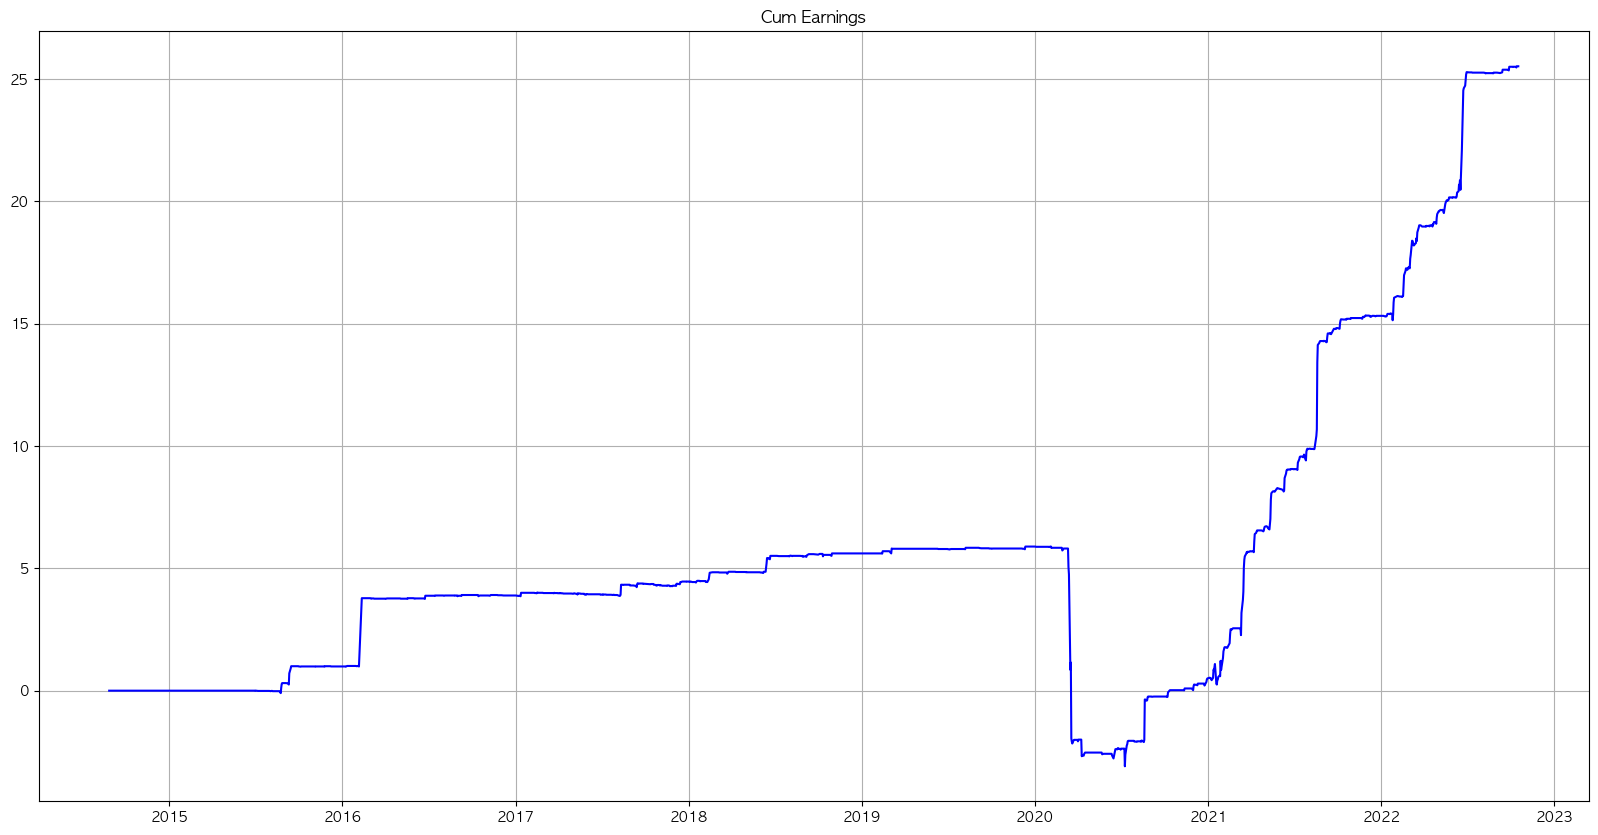

In [580]:
Nominal_PNL_df_cumsum = Nominal_PNL_df.cumsum()
reg = all_date_df.add(Nominal_PNL_df_cumsum, fill_value=0)

plt.figure(figsize=(20,10))
plt.title('Cum Earnings')
plt.plot(reg.fillna(method='ffill').fillna(0), color='b' ,label='Cum Earning')
plt.grid()
plt.show()

In [587]:
Nominal_PNL_df

,PNL
2015-07-01,-0.01
2015-07-02,0.01
2015-07-06,-0.01
2015-07-07,0.00
2015-08-03,-0.01
...,...
2022-09-28,0.15
2022-10-06,-0.01
2022-10-07,0.01
2022-10-13,-0.03


<AxesSubplot:xlabel='날짜'>

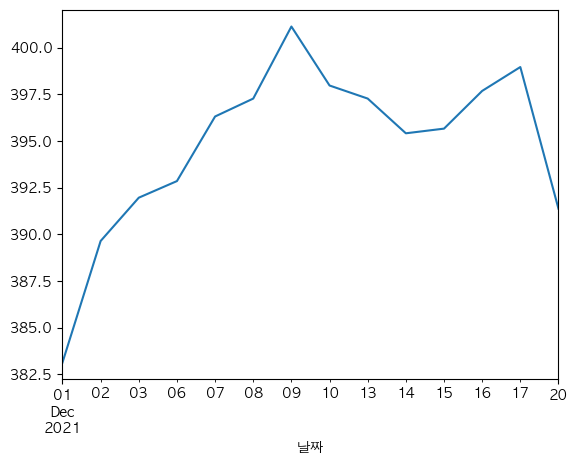

# ------------------------------ Back Test ------------------------------------

In [810]:
cost_df = pd.DataFrame()
pnl_df = pd.DataFrame()
eq_pnl_df = pd.DataFrame()

pnl = pd.DataFrame(index=g_reg.columns, columns=['cost', 'path'])
port = []
possible_inst = sliding_window_view(g_reg.index, 3)
holding_p = []
budget = 10000
budget_df = pd.DataFrame(columns=['budget'])

init_position_date = 0
holding_position_date = 0

#for inv_idx in tqdm(g_reg.columns[-2000:-1990]):
for inv_idx in tqdm(g_reg.columns[-1816:]):    
    
    try:
        
        idx = inv_idx
        s0 = kospi200.loc[idx]    

        '''필요 df'''
        check = g_reg[idx]
        p_check = p_reg[idx]
        #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''1. k범위 정하기'''
        #otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(testp, s0, -0.08)
        atm_k = atm_mapping(testp, s0)

        '''1. 들고 있는 포지션 있는지 확인하기'''
        '''holding_p에 데이터 있는지 확인'''
        if holding_p == []:
            pass
        
        else:
            holding_position_date += 1
            pnl_ch = 0
            eq = len(holding_p)
            for port in holding_p:
                '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                 
                if pd.isna(tmp_cost) is False:
                    pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                    budget += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                else:
                    pnl_ch += 0
                    budget += 0
                    
            pnl_df.loc[idx, 'pnl'] = pnl_ch
            eq_pnl_df.loc[idx, 'pnl'] = pnl_ch / eq

            '''청산 체크'''
            for port in holding_p:
                if g_reg.loc[port, idx] >= 0 or pd.isna(g_reg.loc[port, idx]) == True:          
                    del holding_p[np.where(np.array(holding_p)==port)[0][0]]
                else:
                    pass
        
        '''2. 신규 들고갈 포지션 잡기'''
        new_position_check = check.iloc[np.where(check.index >= otm_k_p)]

        if (new_position_check < 0).sum() == 0:
            
            # new_cost = pd.DataFrame(data=np.zeros(1), index=['cost'], columns=[idx]).T
            # cost_df = pd.concat([cost_df, new_cost], axis=0)
            pass
            
        else:

            today_new_position = pd.DataFrame(new_position_check.iloc[np.where(new_position_check < 0)])

            tmp_cost = 0

            for new_port_idx in today_new_position.index:
                
                init_position_date += 1
                # if new_port_idx in holding_p:
                #     pass
                
                # else:
                aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3])
                tmp_cost += -cal_cost(aa)
                
                '''버젯에 추가 됨 -이면 돈받고 물건 산거고, +면 돈 내고 물건을 산거임'''
                budget += -cal_cost(aa)
                
                #aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3]).to_numpy()
                    
                for values in today_new_position.index:
                    holding_p.append(values)
                
            new_cost = pd.DataFrame(data=tmp_cost, index=['cost'], columns=[idx]).T

            cost_df = pd.concat([cost_df, new_cost], axis=0)
            
            new_holding_portfolio = today_new_position.index.to_list()

                    
        '''3. 현재 들고 있는 포지션에 추가하기'''
        if 'new_holding_portfolio' in locals():
            pnl.loc[idx]['cost'] = new_cost.values[0][0]
            del new_holding_portfolio
        else:
            pass

        budget_df.loc[idx, 'budget'] = budget    
    except:
        pass

Nominal_PNL_df = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])

all_date_df = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])


100%|██████████| 1816/1816 [00:24<00:00, 75.14it/s]


In [849]:
print('# Holding Dates :', holding_position_date + init_position_date)
print('# Init Trade Dates :', init_position_date)


# Holding Dates : 929
# Init Trade Dates : 458


In [864]:
Nominal_PNL_df.iloc[np.where(Nominal_PNL_df<-2)[0]]

,PNL
2020-03-16,-3.30
2020-03-18,-3.00
2021-12-10,-4.82


<AxesSubplot:>

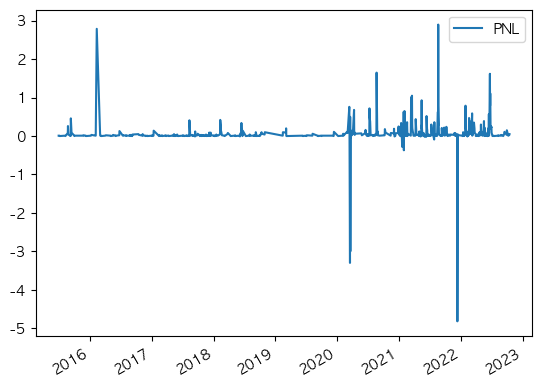

In [862]:
Nominal_PNL_df.plot()

(-1.0, 1.0)

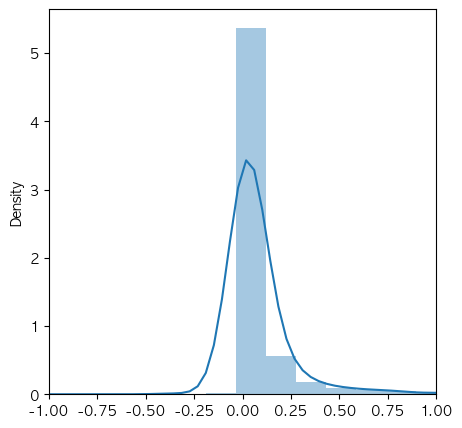

In [858]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.distplot(Nominal_PNL_df)
plt.xlim(-1, 1)
plt.ylim(0, 0.5)

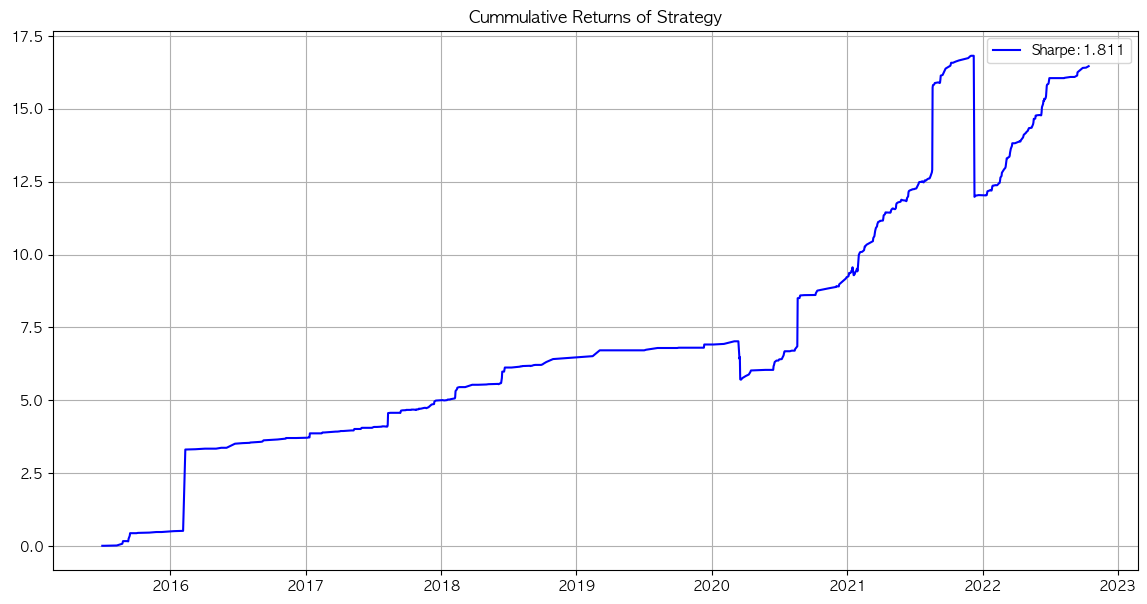

In [797]:
sharpe = (eq_pnl_df.mean() * 252 / (eq_pnl_df.std() * np.sqrt(252))).item()
plt.figure(figsize=(14,7))
plt.title('Cummulative Returns of Strategy')
plt.plot(eq_pnl_df.cumsum(), color='b', label=f'Sharpe:{np.round(sharpe, 3)}')
plt.grid()
plt.legend()
plt.show()

홀딩 기간 보기

In [872]:
holding_check_g = g_reg.T.loc[eq_pnl_df.index[0]:].T
holding_check_g
#for x in holding_check_g.columns:



,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,...,2022-09-30,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-11,2022-10-12,2022-10-13,2022-10-14,2022-10-17
107.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [895]:
idx = holding_check_g.columns[0]

idx = inv_idx
s0 = kospi200.loc[idx]    

'''필요 df'''
check = g_reg[idx]
p_check = p_reg[idx]
#possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''1. k범위 정하기'''
#otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(testp, s0, -0.08)
atm_k = atm_mapping(testp, s0)

check_g = holding_check_g[idx].iloc[np.where(holding_check_g[idx].index > otm_k_p)[0]].dropna()
check_g

267.5    0.0128
270.0    0.0192
272.5    0.0064
275.0    0.0080
277.5    0.0240
280.0    0.0176
Name: 2022-10-17 00:00:00, dtype: float64

In [899]:
np.where(check_g<0)[0]

array([], dtype=int64)

In [891]:
holding_check_g[idx].iloc[np.where(holding_check_g[idx].index > otm_k_p)[0]].dropna()

267.5    0.0128
270.0    0.0192
272.5    0.0064
275.0    0.0080
277.5    0.0240
280.0    0.0176
Name: 2022-10-17 00:00:00, dtype: float64

In [884]:
otm_k_p

265.0

In [883]:
s0

289.57

In [725]:
kospi200.iloc[-2032:-2010].T.dropna()

날짜
2014-08-27    265.88
2014-08-28    266.19
2014-08-29    265.41
2014-09-01    265.27
2014-09-02    262.61
2014-09-03    262.27
2014-09-04    263.19
2014-09-05    262.09
2014-09-11    259.80
2014-09-12    261.39
2014-09-15    260.56
2014-09-16    261.45
2014-09-17    264.01
2014-09-18    261.72
2014-09-19    262.31
2014-09-22    260.15
2014-09-23    258.49
2014-09-24    258.88
2014-09-25    258.46
2014-09-26    258.33
2014-09-29    257.95
2014-09-30    256.77
Name: 종가, dtype: float64

In [726]:
g_reg.T.iloc[-2000:-1990].T.dropna()

,2014-08-27,2014-08-28,2014-08-29,2014-09-01,2014-09-02,2014-09-03,2014-09-04,2014-09-05,2014-09-11,2014-09-12
235.0,-0.0016,-0.0016,-0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0016,0.0000
237.5,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0000,0.0000,0.0016,0.0032
240.0,0.0000,0.0000,-0.0016,-0.0016,-0.0016,-0.0016,0.0000,0.0000,0.0048,0.0016
242.5,0.0000,-0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0000,0.0064,0.0048
245.0,0.0000,0.0032,0.0000,0.0000,0.0016,0.0000,-0.0016,0.0000,0.0128,0.0032
247.5,0.0032,0.0000,0.0016,0.0016,-0.0016,0.0000,0.0032,0.0032,0.0112,0.0128
250.0,0.0032,0.0032,0.0032,0.0016,0.0032,0.0048,-0.0032,0.0016,0.0304,0.0224


In [727]:
p_reg.T.iloc[-2000:-1990].T.dropna()

,2014-08-27,2014-08-28,2014-08-29,2014-09-01,2014-09-02,2014-09-03,2014-09-04,2014-09-05,2014-09-11,2014-09-12
235.0,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.11,0.08
237.5,0.02,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.12,0.09
240.0,0.02,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.14,0.1
242.5,0.03,0.03,0.04,0.02,0.02,0.02,0.01,0.01,0.17,0.13
245.0,0.04,0.04,0.04,0.02,0.02,0.02,0.01,0.01,0.23,0.17
247.5,0.05,0.04,0.05,0.03,0.03,0.03,0.02,0.01,0.33,0.24
250.0,0.06,0.06,0.06,0.04,0.05,0.04,0.02,0.01,0.51,0.33
252.5,0.09,0.08,0.08,0.06,0.06,0.05,0.04,0.03,0.76,0.5
255.0,0.14,0.12,0.12,0.09,0.09,0.09,0.04,0.06,1.2,0.81
257.5,0.21,0.19,0.2,0.15,0.21,0.2,0.1,0.12,5.1,1.31


In [738]:
262.27 * 0.92

241.2884

In [757]:
import yfinance as yf

test = yf.download('TSLA')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [770]:
np.exp(np.log(test).diff(1).cumsum().dropna())

,Close
Date,
2010-06-30,0.997489
2010-07-01,0.919213
2010-07-02,0.803683
2010-07-06,0.674341
2010-07-07,0.661364
...,...
2023-04-18,115.724128
2023-04-19,113.388422
2023-04-20,102.337781


In [771]:
test.pct_change()

,Close
Date,
2010-06-29,NaN
2010-06-30,-0.002511
2010-07-01,-0.078473
2010-07-02,-0.125683
2010-07-06,-0.160937
...,...
2023-04-18,-0.014596
2023-04-19,-0.020183
2023-04-20,-0.097458


In [751]:
Nominal_PNL_df

,PNL
2014-08-28,0.01
2014-08-29,0.01
2014-09-02,0.02
2014-09-03,-0.01
2014-09-04,0.03
...,...
2022-09-28,0.15
2022-10-06,0.01
2022-10-07,0.01
2022-10-13,0.03


In [753]:
Nominal_PNL_df.cumsum()

,PNL
2014-08-28,0.01
2014-08-29,0.02
2014-09-02,0.04
2014-09-03,0.03
2014-09-04,0.06
...,...
2022-09-28,47.15
2022-10-06,47.16
2022-10-07,47.17
2022-10-13,47.20


<AxesSubplot:>

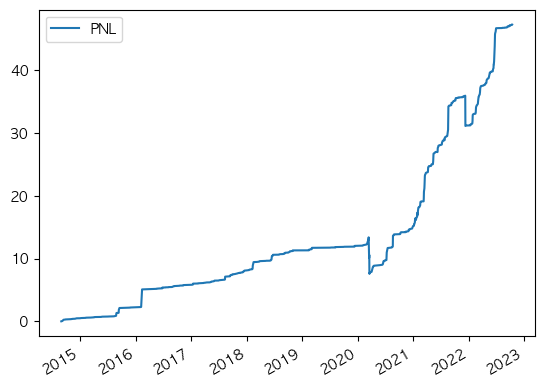

In [752]:
Nominal_PNL_df.cumsum().plot()

In [694]:
Nominal_PNL_df

,PNL
2014-08-28,0.01
2014-08-29,0.01
2014-09-02,0.02
2014-09-03,-0.01
2014-09-04,0.03
...,...
2022-09-28,0.15
2022-10-06,0.01
2022-10-07,0.01
2022-10-13,0.03


<AxesSubplot:>

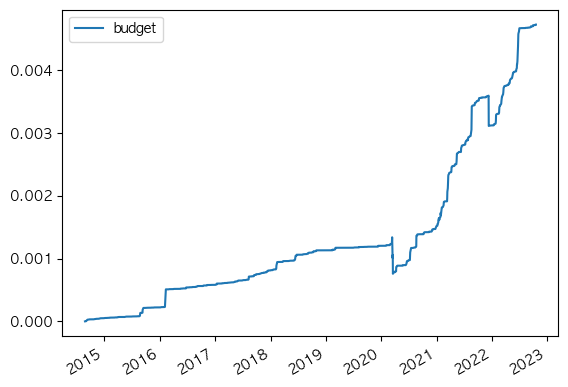

In [692]:
((budget_df - budget_df.iloc[0])/budget_df.iloc[0]).plot()

<AxesSubplot:>

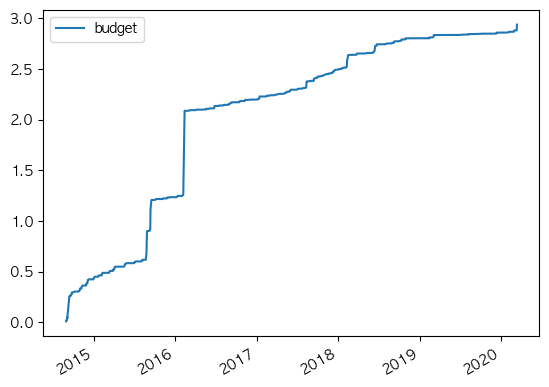

In [657]:
budget_df.dropna().pct_change().cumsum().plot()

In [648]:
budget_df.dropna().apply(lambda x: x - 10000)

,budget
2014-08-27,0
2014-08-28,0.01
2014-08-29,0.02
2014-09-01,0.02
2014-09-02,0.05
...,...
2020-03-06,12.55
2020-03-09,12.55
2020-03-10,12.55
2020-03-11,12.55


In [602]:
holding_p, idx

([227.5, 220.0, 227.5, 220.0, 227.5], Timestamp('2007-12-14 00:00:00'))

In [616]:
idx = dt.datetime.strptime('2007-12-17', '%Y-%m-%d')
idx

datetime.datetime(2007, 12, 17, 0, 0)

In [607]:
port = 227.5

possible_inst[np.where(possible_inst[:,0] == port)][0]

array([227.5, 230. , 232.5])

In [160]:
tmp_a = []
for x in holding_p.values():
    for aa in x:
        tmp_a.append(aa)

set(tmp_a)

{215.0, 217.5, 220.0, 222.5, 225.0, 227.5, 230.0, 235.0, 237.5}

In [66]:
np.where(possible_inst[:,0] == 227.5)

(array([13]),)

In [75]:
cal_cost(pd.DataFrame(p_c
                      heck.loc[possible_inst[np.where(possible_inst[:,0] == 227.5)][0]]))

0.03

In [74]:
pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == 227.5)][0]])

,2007-12-11
227.5,0.03
230.0,0.06
232.5,0.12


In [636]:
Nominal_PNL_df

,PNL
2007-12-04,-0.01
2007-12-05,0.03
2007-12-11,-0.06
2007-12-12,0.11
2007-12-13,-0.25
2007-12-14,-0.26


In [140]:
aa = [x for x in holding_p.keys()][-1]

aa

Timestamp('2007-12-24 00:00:00')

In [150]:
holding_p

{Timestamp('2007-12-04 00:00:00'): [227.5],
 Timestamp('2007-12-11 00:00:00'): [235.0],
 Timestamp('2007-12-13 00:00:00'): [227.5],
 Timestamp('2007-12-14 00:00:00'): [220.0, 227.5],
 Timestamp('2007-12-17 00:00:00'): [215.0],
 Timestamp('2007-12-18 00:00:00'): [220.0, 225.0],
 Timestamp('2007-12-20 00:00:00'): [217.5],
 Timestamp('2007-12-21 00:00:00'): [222.5, 230.0],
 Timestamp('2007-12-24 00:00:00'): [237.5]}

In [137]:
'''여기서 key는 데이트'''
pnl_ch = 0

'''pnl 추가하는거'''
for keys in holding_p.keys():
    for x in holding_p[keys]:
        print(x)
        pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == x)][0]]))

'''청산 여부 체크하기'''
arr = np.array([])
for x in holding_p.values():
    arr = np.append(arr, x)

tmptmptmp = g_reg.loc[arr, idx]

for keys, values in holding_p.items():
    if tmptmptmp.loc[values].item() > 0 is True :
        holding_p[keys].remove(values)
    else:
        pass

pnl_ch

227.5
235.0
227.5
220.0
227.5
215.0
220.0
225.0
217.5
222.5
230.0
227.5
237.5


ValueError: can only convert an array of size 1 to a Python scalar

In [146]:
tmptmptmp

227.5   -0.0128
235.0    0.0528
227.5   -0.0128
220.0    0.0048
227.5   -0.0128
215.0    0.0048
220.0    0.0048
225.0    0.0112
217.5    0.0064
222.5    0.0192
230.0    0.0592
227.5   -0.0128
237.5   -0.0064
Name: 2007-12-24 00:00:00, dtype: float64

In [142]:
holding_p[aa].remove(227.5)

In [143]:
holding_p[aa]

[237.5]

In [118]:
keys

Timestamp('2007-12-11 00:00:00')

In [117]:
holding_p['keys']

{Timestamp('2007-12-04 00:00:00'): array([227.5]),
 Timestamp('2007-12-11 00:00:00'): array([235.])}

In [35]:
len(holding_p)

1

In [36]:
cost_df

,cost
2007-12-04,-0.01


In [78]:
inv_idx = g_reg.columns[4]
idx = inv_idx
s0 = kospi200.loc[idx]    

'''필요 df'''
check = g_reg[idx]
p_check = p_reg[idx]
possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), '종가')]).T

'''1. k범위 정하기'''
#otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(testp, s0, -0.08)
atm_k = atm_mapping(testp, s0)




In [79]:
g_reg.loc[227.5]

2007-12-03    0.0288
2007-12-04   -0.0016
2007-12-05    0.0048
2007-12-06    0.0080
2007-12-07    0.0144
               ...  
2022-10-11    0.0000
2022-10-12    0.0000
2022-10-13    0.0080
2022-10-14    0.0048
2022-10-17    0.0000
Name: 227.5, Length: 3674, dtype: float64

In [48]:
g_reg.loc[227.5, idx].item()

3600.0

In [26]:
'''g체크'''
for buying_date, buying_port in holding_p.items():
    
    ch = 0
    remain_port = {}
    '''holding 여부'''
    if g_reg.loc[buying_port, idx].item() > 0:
        print(g_reg.loc[buying_port, idx].item())
        '''pnl에 뭔가 추가'''
        print('보유')
        ch += cal_cost(pd.DataFrame(p_check.iloc[np.where(p_check.index == buying_port[0])[0][0]:np.where(p_check.index == buying_port[0])[0][0]+3]))
        remain_port[buying_date] = buying_port
        
        pass
    else:
        print('sold')
        ch += cal_cost(pd.DataFrame(p_check.iloc[np.where(p_check.index == buying_port[0])[0][0]:np.where(p_check.index == buying_port[0])[0][0]+3]))
    
    holding_p = remain_port
    
    pnl.loc
    
    print(ch)
    
holding_p

sold
0.0
sold
-0.03
sold
0.0


ValueError: can only convert an array of size 1 to a Python scalar

In [551]:
new_cost.values[0][0]

0.03

In [561]:
pnl

,cost,path
2015-07-29,NaN,NaN
2015-07-30,NaN,NaN
2015-07-31,NaN,NaN
2015-08-03,0.02,NaN
2015-08-04,NaN,NaN
2015-08-05,NaN,NaN
2015-08-06,NaN,NaN
2015-08-07,0.01,NaN
2015-08-10,NaN,NaN
2015-08-11,NaN,NaN


In [537]:
g_reg

,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,...,2015-09-24,2015-09-25,2015-09-30,2015-10-01,2015-10-02,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-12
192.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0016,0.0016
195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.0016,0.0000,0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
197.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0032,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0016,0.0016
200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0016,-0.0016
202.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0016,0.0048,0.0000,0.0016,0.0000,0.0000,0.0000,0.0000,-0.0016,0.0000
205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0016,-0.0032,0.0000,0.0000,0.0016,0.0000,0.0000,0.0000,-0.0000,0.0016
207.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0016,0.0016,0.0016,-0.0016,-0.0016,0.0000,0.0000,0.0000,0.0032,0.0016
210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,...,0.0016,0.0048,0.0016,0.0016,0.0016,0.0000,0.0000,0.0000,-0.0016,-0.0016
212.5,NaN,NaN,-0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0048,0.0016,0.0000,-0.0016,0.0000,0.0000,0.0000,0.0000,0.0048,0.0032
215.0,-0.0016,0.0016,0.0000,0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0016,0.0032,0.0032,0.0032,0.0000,0.0000,0.0000,0.0000,0.0016,0.0032


2015-08-03 00:00:00
2015-08-07 00:00:00
2015-08-24 00:00:00
2015-08-25 00:00:00
2015-09-07 00:00:00
2015-09-09 00:00:00
2015-09-10 00:00:00
2015-10-01 00:00:00
2015-10-05 00:00:00


In [589]:
#for idx_num in holding_p.keys():
idx_num = 3
idx = g_reg.columns[idx_num] # 다음기간의 Pnl

try:
    for x in range(len(holding_p[idx])): # 기간에 포함된 포트폴리오의 값
    
        tmp_hp = holding_p[idx][0] # 뒤에는 포트폴리오 값
        print(tmp_hp)
        # g 값
        if t
except:
    print('No Inv')



220.0


In [520]:
idx = g_reg.columns[3]

#for x in holding_p[idx]:
tmp_hp = holding_p[idx][0]

if g_reg[idx].loc[tmp_hp] < 0 :
    tmp_hp

    aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == tmp_hp)[0][0]:np.where(p_check.index == tmp_hp)[0][0]+3])
    cal_cost(aa)
    
else:
    pass

cal_cost(aa)

0.35000000000000003

True

True

In [382]:
holding_p[idx]

KeyError: Timestamp('2015-10-12 00:00:00')

In [534]:
cost_df = pd.DataFrame()
pnl_df = pd.DataFrame()
pnl = pd.DataFrame(index=g_reg.columns, columns=['cost', 'path'])
port = []
possible_inst = sliding_window_view(g_reg.index, 3)
holding_p = []

for inv_idx in tqdm(g_reg.columns):
#    try:
#for inv_idx in tqdm(g_reg.columns[-2000:]):
    try:
        
        idx = inv_idx
        s0 = kospi200.loc[idx]    

        '''필요 df'''
        check = g_reg[idx]
        p_check = p_reg[idx]
        #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''1. k범위 정하기'''
        #otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(testp, s0, -0.08)
        atm_k = atm_mapping(testp, s0)

        '''1. 들고 있는 포지션 있는지 확인하기'''
        '''holding_p에 데이터 있는지 확인'''
        if holding_p == []:
            pass
        
        else:
            
            pnl_ch = 0
            
            for port in holding_p:
                '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]])) 
                if pd.isna(tmp_cost) is False:
                    pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                else:
                    pnl_ch += 0
                    
            pnl_df.loc[idx, 'pnl'] = pnl_ch

            '''청산 체크'''
            for port in holding_p:
                if g_reg.loc[port, idx] >= 0 or pd.isna(g_reg.loc[port, idx]) == True:          
                    del holding_p[np.where(np.array(holding_p)==port)[0][0]]
                else:
                    pass
        
        '''2. 신규 들고갈 포지션 잡기'''
        new_position_check = check.iloc[np.where(check.index >= otm_k_p)]

        if (new_position_check < 0).sum() == 0:
            
            # new_cost = pd.DataFrame(data=np.zeros(1), index=['cost'], columns=[idx]).T
            # cost_df = pd.concat([cost_df, new_cost], axis=0)
            pass
            
        else:

            today_new_position = pd.DataFrame(new_position_check.iloc[np.where(new_position_check < 0)])

            tmp_cost = 0

            for new_port_idx in today_new_position.index:
                
                today_new_position.loc[new_port_idx]

                aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3])
                tmp_cost += cal_cost(aa)
                #aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3]).to_numpy()
                
                for values in today_new_position.index:
                    holding_p.append(values)
                
            new_cost = pd.DataFrame(data=tmp_cost, index=['cost'], columns=[idx]).T

            cost_df = pd.concat([cost_df, new_cost], axis=0)
            
            new_holding_portfolio = today_new_position.index.to_list()

                    
        '''3. 현재 들고 있는 포지션에 추가하기'''
        if 'new_holding_portfolio' in locals():
            pnl.loc[idx]['cost'] = new_cost.values[0][0]
            del new_holding_portfolio
        else:
            pass

    except:
        pass

Nominal_PNL_df = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])

all_date_df = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])


100%|██████████| 3674/3674 [00:41<00:00, 87.75it/s] 


<AxesSubplot:>

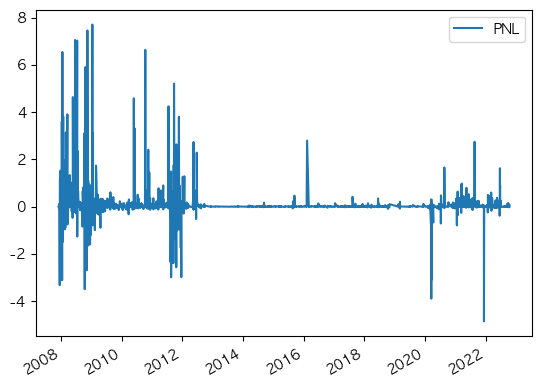

In [535]:
Nominal_PNL_df.plot()

<AxesSubplot:>

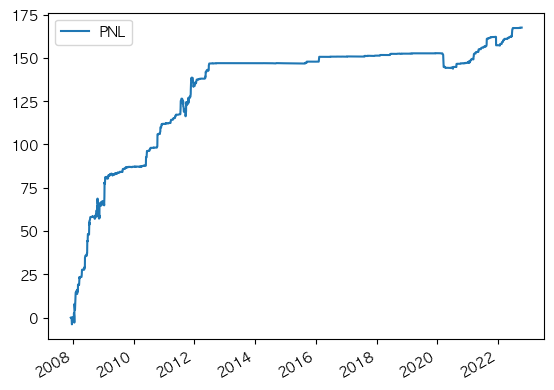

In [536]:
Nominal_PNL_df.cumsum().plot()

<AxesSubplot:>

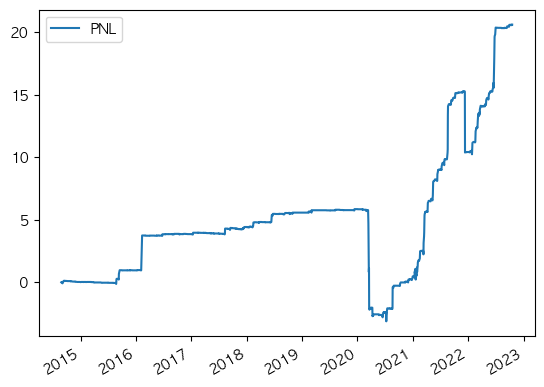

In [515]:
'''Nominal Price Change'''
tmp = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])
tmp = tmp.cumsum()
aa = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])
reg = aa.add(tmp, fill_value=0)
reg.fillna(method='ffill').fillna(0).plot()

In [470]:
tmp = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])
pnl

,PNL
2014-08-28,False
2014-08-29,False
2014-09-02,False
2014-09-03,False
2014-09-04,False
...,...
2022-09-28,False
2022-10-06,False
2022-10-07,False
2022-10-13,False


In [461]:
tmp = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])
#tmp.loc[dt.datetime.strptime('2014-08-27', '%Y-%m-%d'), 'PNL'] = 1
#test = tmp.sort_index().pct_change().dropna()
tmp * 250000

,PNL
2014-08-28,-2500.0
2014-08-29,2500.0
2014-09-02,-5000.0
2014-09-03,-7500.0
2014-09-04,-7500.0
...,...
2022-09-28,37500.0
2022-10-06,-2500.0
2022-10-07,2500.0
2022-10-13,-7500.0


<AxesSubplot:>

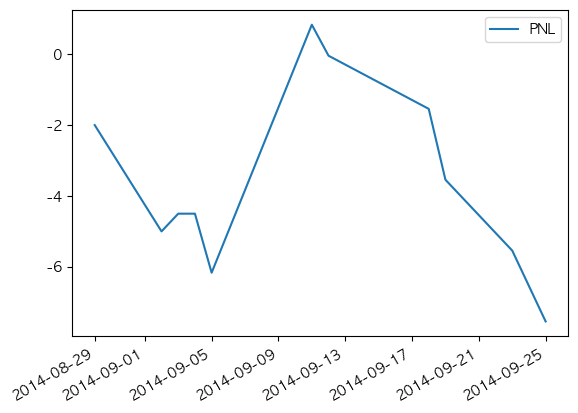

In [397]:
aaaa = (tmp).pct_change().dropna()
aaaa.iloc[np.where(aaaa != np.inf)[0]].cumsum().plot()

In [386]:
(tmp).pct_change().dropna() != np.inf

,PNL
2014-08-29,False
2014-09-02,False
2014-09-03,False
2014-09-04,False
2014-09-05,False
...,...
2022-09-28,False
2022-10-06,False
2022-10-07,False
2022-10-13,False


In [333]:
tmp = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])
tmp

,PNL
2014-08-28,-0.01
2014-08-29,0.01
2014-09-02,-0.02
2014-09-03,-0.03
2014-09-04,-0.03
...,...
2022-09-28,0.15
2022-10-06,-0.01
2022-10-07,0.01
2022-10-13,-0.03


In [288]:
cost_df

,cost
2014-08-28,-0.01
2014-09-02,-0.02
2014-09-03,-0.01
2014-09-04,-0.03
2014-09-18,-0.01
...,...
2022-09-08,-0.01
2022-09-13,-0.02
2022-09-27,-0.03
2022-10-06,-0.01


In [299]:
[pnl, cost_df]

,cost,path
2007-12-03,NaN,NaN
2007-12-04,NaN,NaN
2007-12-05,NaN,NaN
2007-12-06,NaN,NaN
2007-12-07,NaN,NaN
...,...,...
2022-09-08,-0.01,NaN
2022-09-13,-0.02,NaN
2022-09-27,-0.03,NaN
2022-10-06,-0.01,NaN


In [245]:
aa = [2,2,1,1]
del aa[np.where(np.array(aa)==2)[0][0]]
aa

[2, 1, 1]

In [229]:
idx

Timestamp('2007-12-07 00:00:00')

In [230]:
g_reg.loc[227.5, idx]

0.0144

In [227]:
holding_p

[227.5]

In [526]:
cost_df = pd.DataFrame()
pnl_df = pd.DataFrame()
pnl = pd.DataFrame(index=g_reg.columns, columns=['cost', 'path'])
port = []
possible_inst = sliding_window_view(g_reg.index, 3)
holding_p = []

#for inv_idx in tqdm(g_reg.columns):
#    try:
for inv_idx in tqdm(g_reg.columns[-2000:]):
    try:
        
        idx = inv_idx
        s0 = kospi200.loc[idx]    

        '''필요 df'''
        check = g_reg[idx]
        p_check = p_reg[idx]
        #possible_inst = sliding_window_view(p_reg[idx].dropna().index, 3)

        testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

        '''1. k범위 정하기'''
        #otm_k_c = otm_mapping(test, s0, 0.08)
        otm_k_p = otm_mapping(testp, s0, -0.12)
        #atm_k = atm_mapping(testp, s0)
        atm_k = otm_mapping(testp, s0, -0.02)

        '''1. 들고 있는 포지션 있는지 확인하기'''
        '''holding_p에 데이터 있는지 확인'''
        if holding_p == []:
            pass
        
        else:
            
            pnl_ch = 0
            
            for port in holding_p:
                '''0으로 갈경우는, 가격이 np.NaN인 경우, g=0이 되도록 그냥 맞춰준다고 생각해보자'''
                # pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                tmp_cost = cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]])) 
                if pd.isna(tmp_cost) is False:
                    pnl_ch += cal_cost(pd.DataFrame(p_check.loc[possible_inst[np.where(possible_inst[:,0] == port)][0]]))
                else:
                    pnl_ch += 0
                    
            pnl_df.loc[idx, 'pnl'] = pnl_ch

            '''청산 체크'''
            for port in holding_p:
                if g_reg.loc[port, idx] >= 0 or pd.isna(g_reg.loc[port, idx]) == True:
                    del holding_p[np.where(np.array(holding_p)==port)[0][0]]
                else:
                    pass
        
        '''2. 신규 들고갈 포지션 잡기'''
        new_position_check = check.iloc[np.where(check.index >= otm_k_p)]

        if (new_position_check < 0).sum() == 0:
            
            # new_cost = pd.DataFrame(data=np.zeros(1), index=['cost'], columns=[idx]).T
            # cost_df = pd.concat([cost_df, new_cost], axis=0)
            pass
            
        else:

            today_new_position = pd.DataFrame(new_position_check.iloc[np.where(new_position_check < 0)])

            tmp_cost = 0

            for new_port_idx in today_new_position.index:
                
                today_new_position.loc[new_port_idx]

                aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3])
                tmp_cost += cal_cost(aa)
                #aa = pd.DataFrame(p_check.iloc[np.where(p_check.index == new_port_idx)[0][0]:np.where(p_check.index == new_port_idx)[0][0]+3]).to_numpy()
                
                for values in today_new_position.index:
                    holding_p.append(values)
                
            new_cost = pd.DataFrame(data=tmp_cost, index=['cost'], columns=[idx]).T

            cost_df = pd.concat([cost_df, new_cost], axis=0)
            
            new_holding_portfolio = today_new_position.index.to_list()

                    
        '''3. 현재 들고 있는 포지션에 추가하기'''
        if 'new_holding_portfolio' in locals():
            pnl.loc[idx]['cost'] = new_cost.values[0][0]
            del new_holding_portfolio
        else:
            pass

    except:
        pass
holding_p
pnl_df

100%|██████████| 2000/2000 [00:28<00:00, 71.04it/s]


,pnl
2014-08-28,-0.01
2014-08-29,-0.01
2014-09-01,-0.02
2014-09-11,0.11
2014-09-12,0.02
...,...
2022-10-11,0.02
2022-10-12,0.00
2022-10-13,0.06
2022-10-14,0.07


<AxesSubplot:>

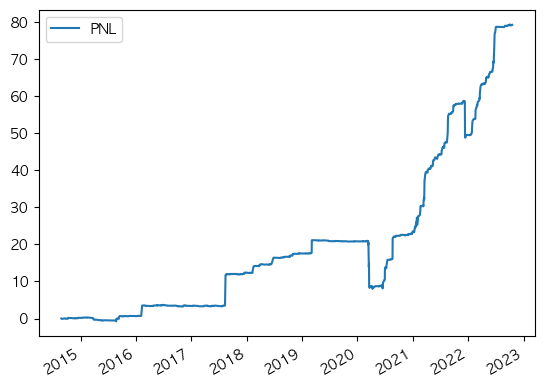

In [527]:
'''Nominal Price Change'''
tmp = pd.DataFrame(pnl_df.add(cost_df, fill_value=0).sum(axis=1), columns=['PNL'])
tmp = tmp.cumsum()
aa = pd.DataFrame(index=g_reg.T.index[-2000:], columns=['PNL'])
reg = aa.add(tmp, fill_value=0)
reg.fillna(method='ffill').fillna(0).plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


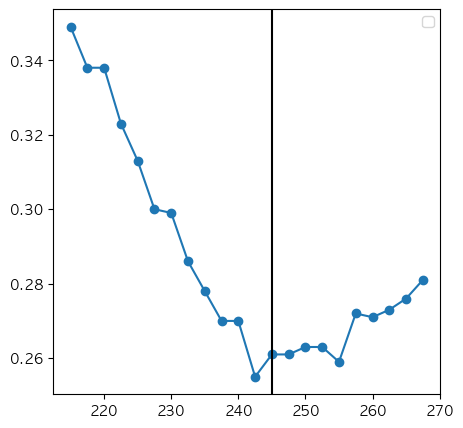

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


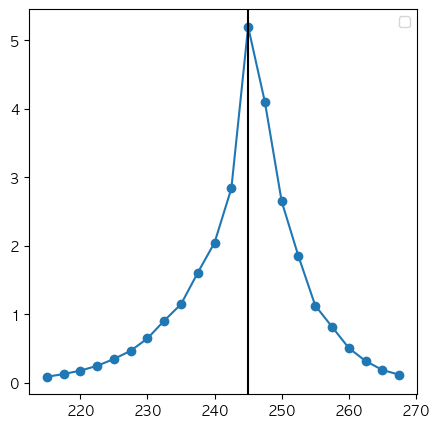

[ 0.0096  0.0128 -0.0032  0.0352 -0.0032  0.056   0.0272]
[0.35 0.47 0.65 0.91 1.15 1.61 2.05 2.84 3.8 ]


In [181]:
idx = kospi_idx[1019]
s0 = kospi200.loc[idx]
'''전처리용 데이터'''
test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''otm 가격'''
otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(test, s0, -0.08)
atm_k = atm_mapping(test, s0)

'''Strike range 잡기'''
k_list_c = test.columns.get_level_values(2).unique().values
k_list_p = testp.columns.get_level_values(2).unique().values

k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


'''임볼 그리기'''
kk = test.columns.get_level_values(2)
kk_p = kk[np.where((kk < atm_k))]
kk_c = kk[np.where((kk >= atm_k))]
iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

plt.figure(figsize=(5,5))
plt.plot(iv_tmp)
plt.axvline(atm_k, color='k')
plt.scatter(x=iv_tmp.index, y=iv_tmp)
plt.legend()
plt.show()

'''가격 그래프'''
pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
plt.figure(figsize=(5,5))
plt.plot(pr_tmp)
plt.axvline(atm_k, color='k')
plt.scatter(x=pr_tmp.index, y=pr_tmp)
plt.legend()
plt.show()


'''port 구성 잡기'''
port_comb_c = sliding_window_view(k_list_c, 3)
port_comb_p = sliding_window_view(k_list_p, 3)

'''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
g_list_c = tmp_dist(kp_list_c, k_list_c)
g_list_p = tmp_dist(kp_list_p, k_list_p)

'''건드릴 포트폴리오'''
iv_port_c = port_comb_c[np.where(g_list_c<0)]
iv_port_p = port_comb_p[np.where(g_list_p<0)]

g_list_p
'''진입은 > -일때 진입
청산 > 다음 위치가 + 일때 청산'''
g_list_p

cost = 0 
for idv_port in iv_port_p:
    ar = pr_tmp.T[iv_port_p[0]].to_numpy()[0]
    '''앞뒤 롱, 가운데 숏'''
    cost += np.round(ar[0] + ar[2] - ar[1], 5)

'''Trading 저장'''
reg = pd.DataFrame(data=np.array([iv_port_p, cost]).reshape(1,2), columns=['port','cost'], index=[idx])


print(g_list_p)
print(kp_list_p)


2011-12-05 00:00:00


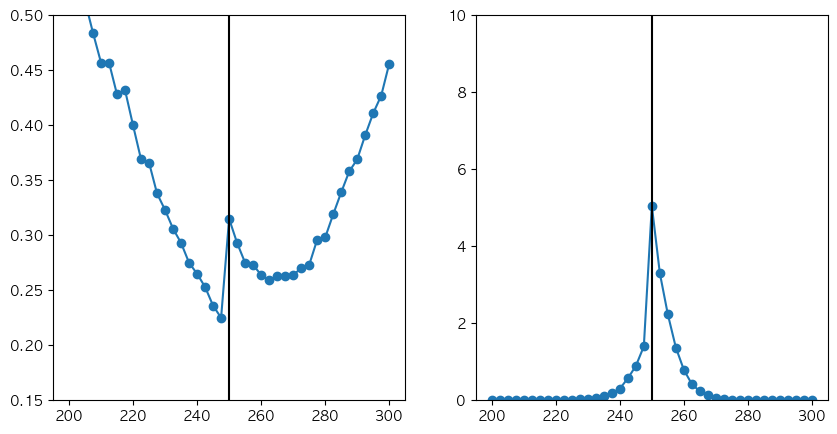

[0.0016 0.0064 0.0048 0.0256 0.008  0.0304 0.0304]
[0.04 0.07 0.11 0.19 0.3  0.57 0.89 1.4  2.1 ]
2011-12-06 00:00:00


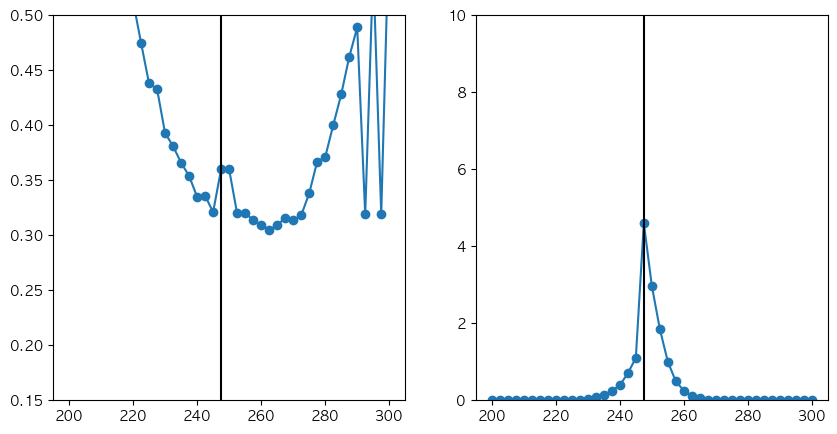

[0.0032 0.0032 0.008  0.0048 0.0272 0.0144 0.0464]
[0.02 0.04 0.08 0.14 0.25 0.39 0.7  1.1  1.79]
2011-12-07 00:00:00


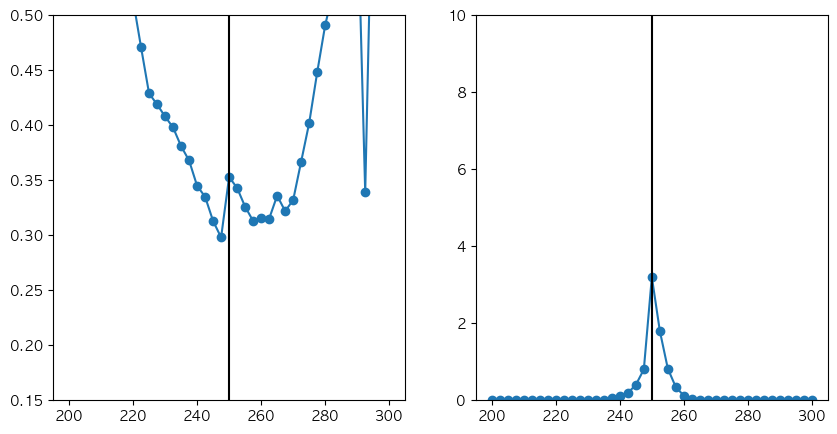

[0.0016 0.0032 0.0048 0.0032 0.0208 0.0304 0.04  ]
[0.01 0.01 0.02 0.05 0.11 0.19 0.4  0.8  1.45]
2011-12-08 00:00:00


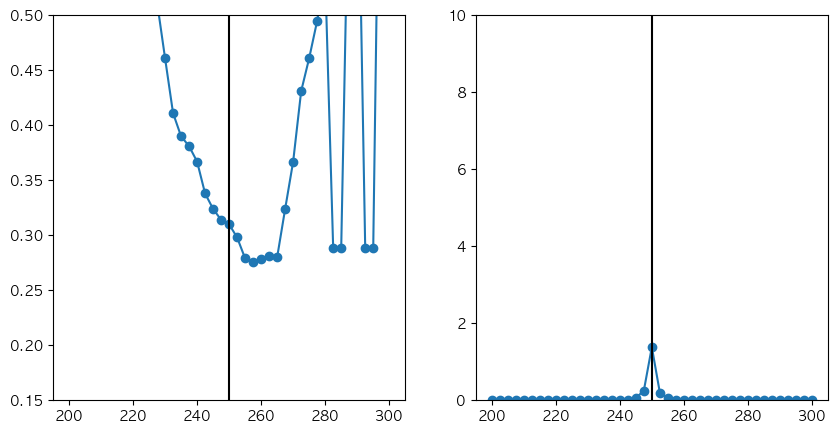

[0.     0.     0.     0.     0.008  0.0224 0.024 ]
[0.01 0.01 0.01 0.01 0.01 0.01 0.06 0.25 0.59]
2011-12-09 00:00:00


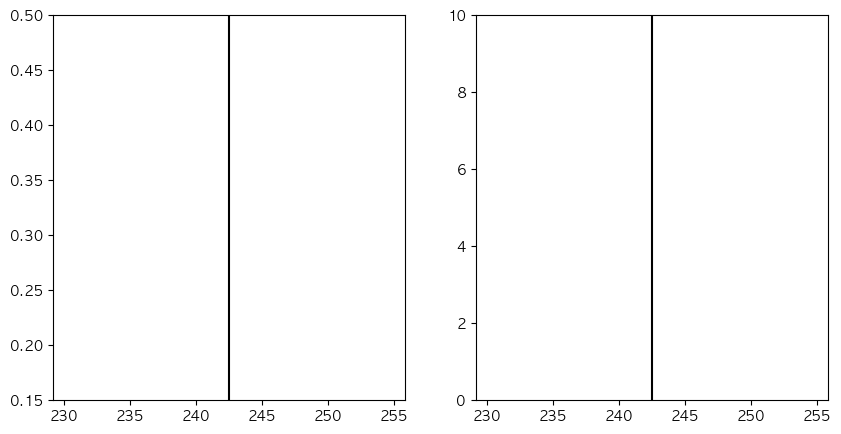

[nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan]
2011-12-12 00:00:00


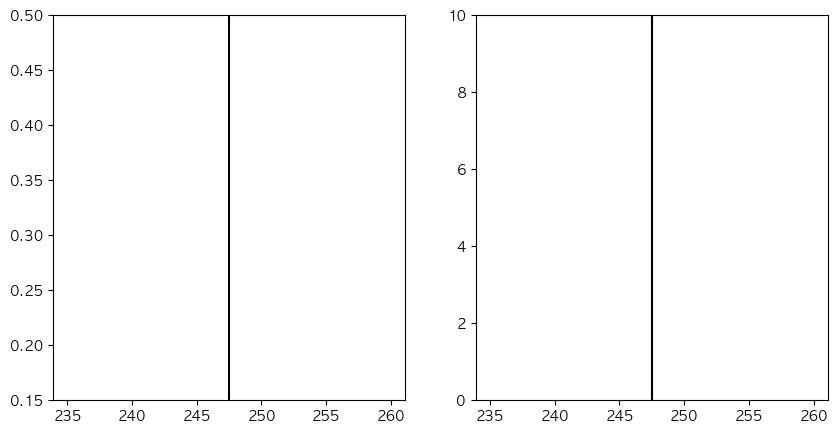

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
2011-12-13 00:00:00


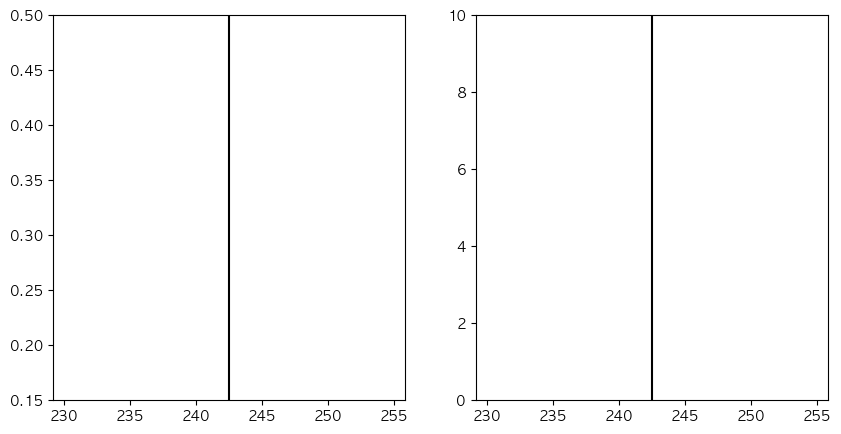

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
2011-12-14 00:00:00


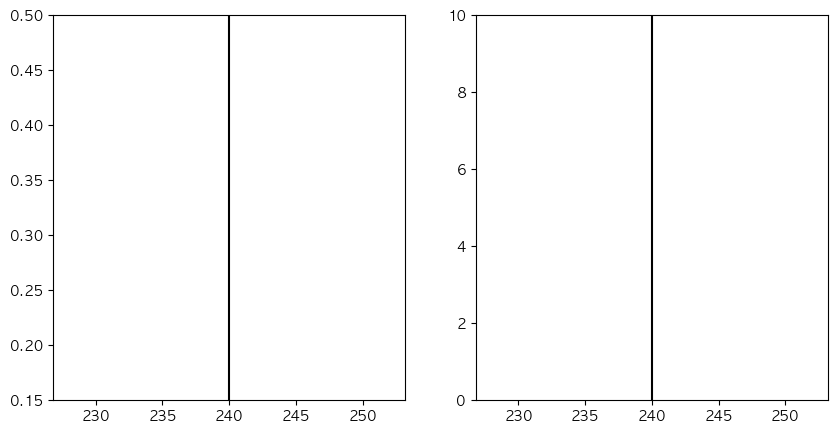

[nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan]
2011-12-15 00:00:00


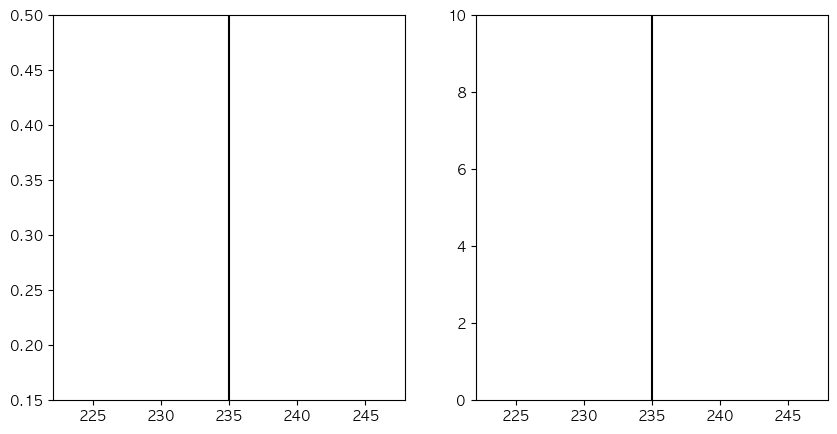

[nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan]
2011-12-16 00:00:00


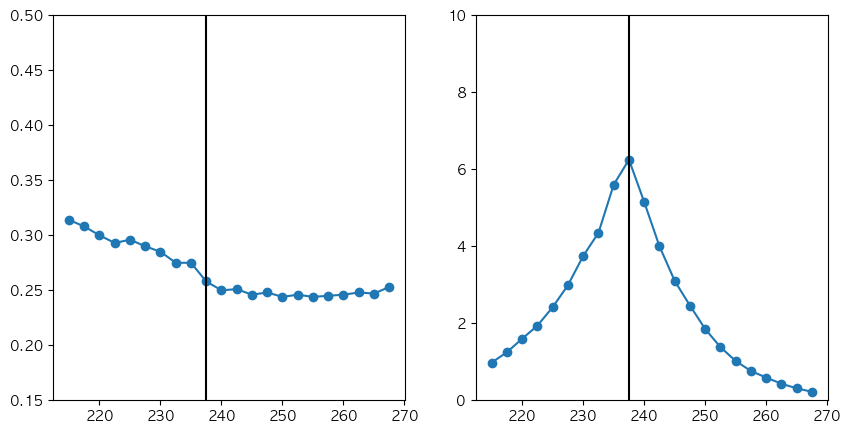

[ 0.0224  0.0144  0.0304 -0.0256  0.104  -0.032 ]
[1.6  1.94 2.42 2.99 3.75 4.35 5.6  6.65]
2011-12-19 00:00:00


IndexError: index -1 is out of bounds for axis 0 with size 0

In [210]:
for x in range(0, 30):
    idx = kospi_idx[999+x]
    s0 = kospi200.loc[idx]
    print(idx)
    '''전처리용 데이터'''
    test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
    testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

    '''otm 가격'''
    otm_k_c = otm_mapping(test, s0, 0.05)
    otm_k_p = otm_mapping(test, s0, -0.05)
    atm_k = atm_mapping(test, s0)

    '''Strike range 잡기'''
    k_list_c = test.columns.get_level_values(2).unique().values
    k_list_p = testp.columns.get_level_values(2).unique().values

    k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
    k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

    kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
    kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


    '''임볼 그리기'''
    kk = test.columns.get_level_values(2)
    kk_p = kk[np.where((kk < atm_k))]
    kk_c = kk[np.where((kk >= atm_k))]
    iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
    iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])



    '''가격 그래프'''
    pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
    pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(iv_tmp)
    plt.axvline(atm_k, color='k')
    plt.scatter(x=iv_tmp.index, y=iv_tmp)
    plt.ylim(0.15, 0.5)
    #plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(pr_tmp)
    plt.axvline(atm_k, color='k')
    plt.scatter(x=pr_tmp.index, y=pr_tmp)
    plt.ylim(0, 10)
    #plt.legend()
    plt.show()


    '''port 구성 잡기'''
    port_comb_c = sliding_window_view(k_list_c, 3)
    port_comb_p = sliding_window_view(k_list_p, 3)

    '''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
    g_list_c = tmp_dist(kp_list_c, k_list_c)
    g_list_p = tmp_dist(kp_list_p, k_list_p)

    '''건드릴 포트폴리오'''
    iv_port_c = port_comb_c[np.where(g_list_c<0)]
    iv_port_p = port_comb_p[np.where(g_list_p<0)]

    g_list_p
    '''진입은 > -일때 진입
    청산 > 다음 위치가 + 일때 청산'''
    g_list_p

    cost = 0 
    for idv_port in iv_port_p:
        ar = pr_tmp.T[iv_port_p[0]].to_numpy()[0]
        '''앞뒤 롱, 가운데 숏'''
        cost += np.round(ar[0] + ar[2] - ar[1], 5)

    '''Trading 저장'''
    reg = pd.DataFrame(data=np.array([iv_port_p, cost]).reshape(1,2), columns=['port','cost'], index=[idx])


    print(g_list_p)
    print(kp_list_p)


In [184]:
idx = kospi_idx[1020]
s0 = kospi200.loc[idx]
'''전처리용 데이터'''
test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''otm 가격'''
otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(test, s0, -0.08)
atm_k = atm_mapping(test, s0)

'''Strike range 잡기'''
k_list_c = test.columns.get_level_values(2).unique().values
k_list_p = testp.columns.get_level_values(2).unique().values

k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


'''임볼 그리기'''
kk = test.columns.get_level_values(2)
kk_p = kk[np.where((kk < atm_k))]
kk_c = kk[np.where((kk >= atm_k))]
iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

# plt.figure(figsize=(5,5))
# plt.plot(iv_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=iv_tmp.index, y=iv_tmp)
# plt.legend()
# plt.show()

'''가격 그래프'''
pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
# plt.figure(figsize=(5,5))
# plt.plot(pr_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=pr_tmp.index, y=pr_tmp)
# plt.legend()
# plt.show()

'''port 구성 잡기'''
port_comb_c = sliding_window_view(k_list_c, 3)
port_comb_p = sliding_window_view(k_list_p, 3)

'''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
g_list_c = tmp_dist(kp_list_c, k_list_c)
g_list_p = tmp_dist(kp_list_p, k_list_p)

'''건드릴 포트폴리오'''
iv_port_c = port_comb_c[np.where(g_list_c<0)]
iv_port_p = port_comb_p[np.where(g_list_p<0)]

g_list_p
'''진입은 > -일때 진입
청산 > 다음 위치가 + 일때 청산'''
g_list_p


print(g_list_p)
print(kp_list_p)


[ 0.0176 -0.0064  0.016   0.016   0.0272  0.0144  0.0496]
[0.28 0.36 0.55 0.7  0.95 1.3  1.82 2.43 3.35]


In [185]:
idx = kospi_idx[1021]
s0 = kospi200.loc[idx]
'''전처리용 데이터'''
test = pd.DataFrame(df.loc[idx, ('C', next_opt_exp(idx), slice(None), slice(None))]).T
testp = pd.DataFrame(df.loc[idx, ('P', next_opt_exp(idx), slice(None), slice(None))]).T

'''otm 가격'''
otm_k_c = otm_mapping(test, s0, 0.08)
otm_k_p = otm_mapping(test, s0, -0.08)
atm_k = atm_mapping(test, s0)

'''Strike range 잡기'''
k_list_c = test.columns.get_level_values(2).unique().values
k_list_p = testp.columns.get_level_values(2).unique().values

k_list_c = k_list_c[np.where((k_list_c >= atm_k) & ( k_list_c <= otm_k_c))]
k_list_p = k_list_p[np.where((k_list_p <= atm_k) & ( k_list_p >= otm_k_p))]

kp_list_c = test.loc[idx, (slice(None), slice(None), k_list_c, '종가')].astype(float).values
kp_list_p = testp.loc[idx, (slice(None), slice(None), k_list_p, '종가')].astype(float).values


'''임볼 그리기'''
kk = test.columns.get_level_values(2)
kk_p = kk[np.where((kk < atm_k))]
kk_c = kk[np.where((kk >= atm_k))]
iv_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '내재변동성')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '내재변동성')])])
iv_tmp = pd.DataFrame(data=iv_tmp.values, index=iv_tmp.index.get_level_values(2).values, columns=[idx])

# plt.figure(figsize=(5,5))
# plt.plot(iv_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=iv_tmp.index, y=iv_tmp)
# plt.legend()
# plt.show()

'''가격 그래프'''
pr_tmp = pd.concat([pd.DataFrame(testp.loc[idx, (slice(None), slice(None), kk_p, '종가')]), pd.DataFrame(test.loc[idx, (slice(None), slice(None), kk_c, '종가')])])
pr_tmp = pd.DataFrame(data=pr_tmp.values, index=pr_tmp.index.get_level_values(2).values, columns=[idx])
# plt.figure(figsize=(5,5))
# plt.plot(pr_tmp)
# plt.axvline(atm_k, color='k')
# plt.scatter(x=pr_tmp.index, y=pr_tmp)
# plt.legend()
# plt.show()

'''port 구성 잡기'''
port_comb_c = sliding_window_view(k_list_c, 3)
port_comb_p = sliding_window_view(k_list_p, 3)

'''g 값, 확률, 3가지 행사가격을 가지고 구해서 양 끝 사이에 존재할 확률을 구했음'''
g_list_c = tmp_dist(kp_list_c, k_list_c)
g_list_p = tmp_dist(kp_list_p, k_list_p)

'''건드릴 포트폴리오'''
iv_port_c = port_comb_c[np.where(g_list_c<0)]
iv_port_p = port_comb_p[np.where(g_list_p<0)]

g_list_p
'''진입은 > -일때 진입
청산 > 다음 위치가 + 일때 청산'''
g_list_p


print(g_list_p)
print(kp_list_p)


[ 0.0128 -0.      0.0192  0.008   0.0288  0.0176  0.0224]
[0.23 0.3  0.45 0.6  0.87 1.19 1.69 2.3  3.05]


In [202]:
init_inv = -(0.65 - 2* 0.91 + 1.15) * 250000
init_inv

5000.000000000005

In [201]:
init_inv = -(0.65 - 2* 0.91 + 1.15) * 250000

ret = (end - init_inv)/init_inv
ret

5.000000000000005

In [271]:
-(0.36 - 2 * 0.45 + 0.6) * 250000

-14999.999999999985

In [197]:
end = -((0.65 - 0.55) + 2 * (-0.91 + 0.7) + (1.15 - 0.95)) * 250000
end

30000.000000000055

In [191]:
-((0.36 - 0.3) + 2 * (-0.55 + 0.45) + (0.7 - 0.6)) *  250000

10000.000000000024

In [135]:
reg

,port,cost
2007-12-03,[],0


,port,cost
2007-12-05,[],0


In [95]:
pd.DataFrame(np.array([iv_port_p, cost]).reshape(1,2))

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_74448/2303185086.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pd.DataFrame(np.array([iv_port_p, cost]).reshape(1,2))


,0,1
0,"[[197.5, 200.0, 202.5], [202.5, 205.0, 207.5],...",0.2


In [96]:
reg = pd.DataFrame(data=np.array([iv_port_p, cost]).reshape(1,2), columns=['port','cost'], index=[idx])
reg


/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_74448/2633559796.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reg = pd.DataFrame(data=np.array([iv_port_p, cost]).reshape(1,2), columns=['port','cost'], index=[idx])


,port,cost
2007-12-03,"[[197.5, 200.0, 202.5], [202.5, 205.0, 207.5],...",0.2


reg

In [38]:
pr_tmp.T

,195.0,197.5,200.0,202.5,205.0,207.5,210.0,212.5,215.0,217.5,...,255.0,257.5,260.0,262.5,265.0,267.5,270.0,272.5,275.0,277.5
2007-12-03,0.03,0.04,0.06,0.07,0.1,0.11,0.15,0.18,0.28,0.52,...,0.93,0.61,0.39,0.22,0.12,0.08,0.06,0.03,0.02,0.02


In [55]:


cost = 0 
for idv_port in iv_port:
    ar = pr_tmp.T[iv_port[0]].to_numpy()[0]
    '''앞뒤 롱, 가운데 숏'''
    cost += np.round(ar[0] + ar[2] - ar[1], 5)
    


0.2